In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Generation
np.random.seed(42)
n_samples = 1000

# Generate features
ad_spend = np.random.uniform(1000, 10000, n_samples)
seasonality = np.random.normal(0, 1, n_samples)
competitor_activity = np.random.uniform(0, 1, n_samples)

# Generate treatment (marketing campaign)
treatment = np.random.binomial(1, 0.5, n_samples)

# Generate outcome (sales)
sales = 100 + 0.01 * ad_spend + 10 * seasonality - 20 * competitor_activity + 50 * treatment + np.random.normal(0, 10, n_samples)

# Create DataFrame
data = pd.DataFrame({
    'ad_spend': ad_spend,
    'seasonality': seasonality,
    'competitor_activity': competitor_activity,
    'treatment': treatment,
    'sales': sales
})

A/B Test Results:
T-statistic: 26.03871482634037
P-value: 1.7768818558378816e-114
Mean difference: 49.128801522842906


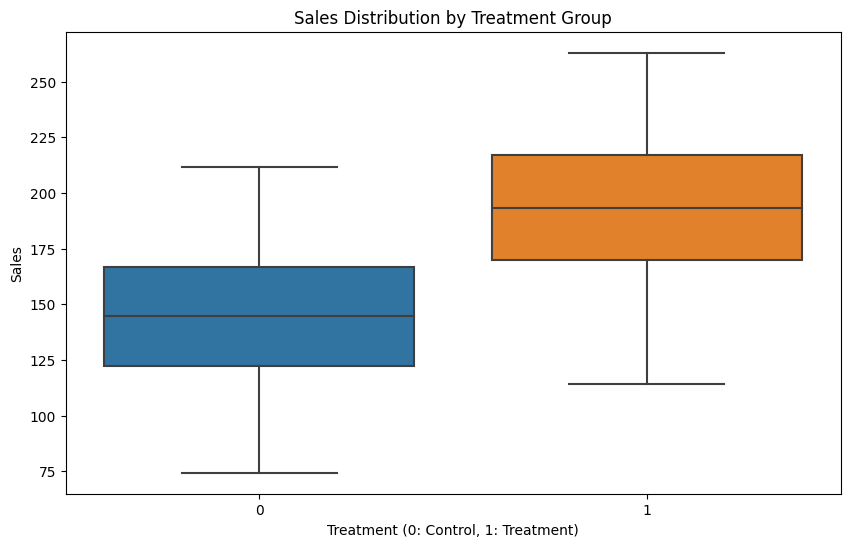

In [3]:
# 2. Simple A/B Testing
def ab_test(data):
    treatment_sales = data[data['treatment'] == 1]['sales']
    control_sales = data[data['treatment'] == 0]['sales']
    
    t_stat, p_value = ttest_ind(treatment_sales, control_sales)
    
    print("A/B Test Results:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print(f"Mean difference: {treatment_sales.mean() - control_sales.mean()}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='treatment', y='sales', data=data)
    plt.title('Sales Distribution by Treatment Group')
    plt.xlabel('Treatment (0: Control, 1: Treatment)')
    plt.ylabel('Sales')
    plt.show()

ab_test(data)


Linear Regression Results:
ad_spend: 0.009934433554209247
seasonality: 9.810708003867632
competitor_activity: -18.61880397770407
treatment: 50.38940113144511
Intercept: 99.05310069135436


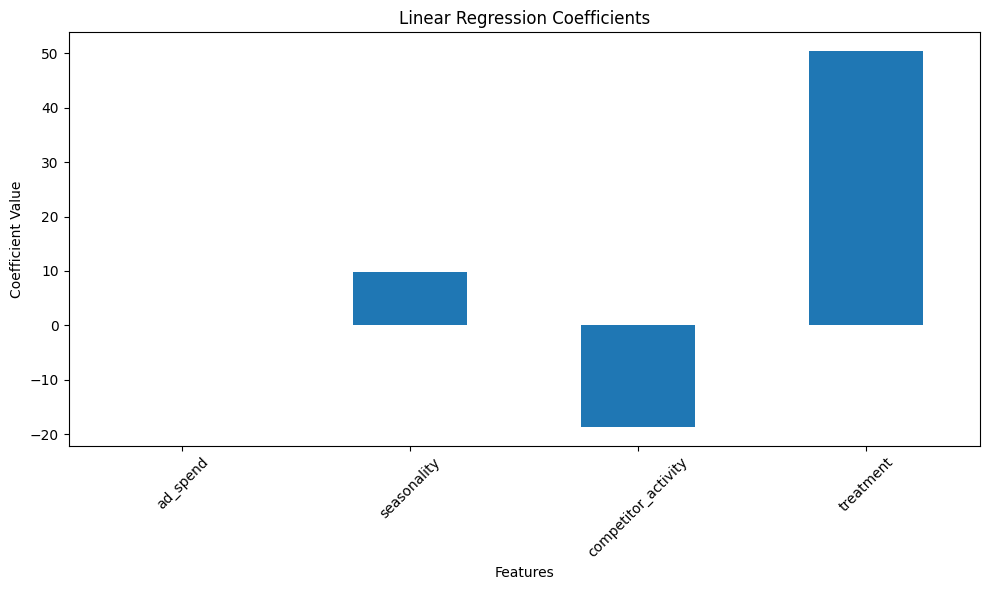

In [4]:
# 3. Linear Regression for Causal Inference
def linear_regression_causal_inference(data):
    X = data[['ad_spend', 'seasonality', 'competitor_activity', 'treatment']]
    y = data['sales']
    
    model = LinearRegression()
    model.fit(X, y)
    
    print("\nLinear Regression Results:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef}")
    print(f"Intercept: {model.intercept_}")

    # Visualization
    plt.figure(figsize=(10, 6))
    coefficients = pd.Series(model.coef_, index=X.columns)
    coefficients.plot(kind='bar')
    plt.title('Linear Regression Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

linear_regression_causal_inference(data)


Propensity Score Matching Results:
Estimated treatment effect: 49.37535653463155


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

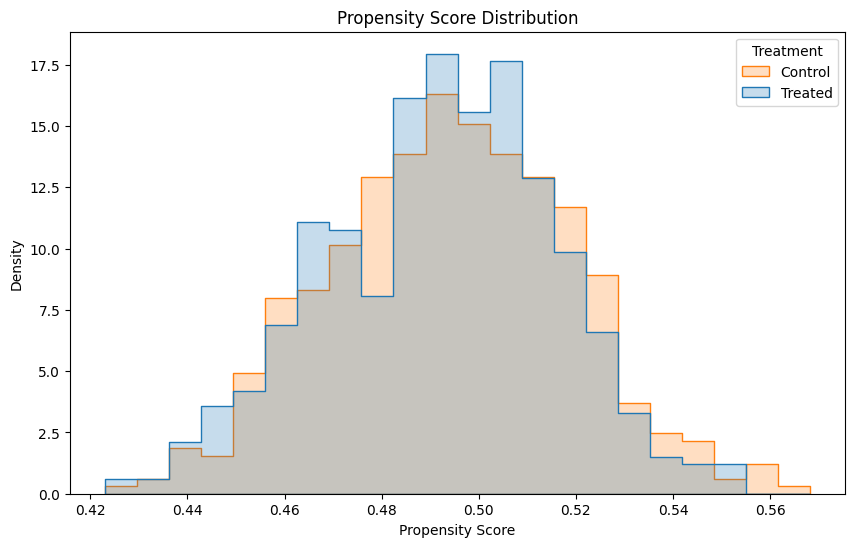

In [5]:
# 4. Propensity Score Matching
def propensity_score_matching(data):
    # Calculate propensity scores
    X = data[['ad_spend', 'seasonality', 'competitor_activity']]
    y = data['treatment']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    ps_model = LogisticRegression(random_state=42)
    ps_model.fit(X_scaled, y)
    
    data['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]
    
    # Match treatment and control groups
    treated = data[data['treatment'] == 1]
    control = data[data['treatment'] == 0]
    
    matched_pairs = []
    for _, treated_row in treated.iterrows():
        best_match = control.iloc[(control['propensity_score'] - treated_row['propensity_score']).abs().argsort()[0]]
        matched_pairs.append((treated_row, best_match))
    
    # Calculate treatment effect
    treatment_effect = np.mean([pair[0]['sales'] - pair[1]['sales'] for pair in matched_pairs])
    
    print("\nPropensity Score Matching Results:")
    print(f"Estimated treatment effect: {treatment_effect}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='propensity_score', hue='treatment', element='step', stat='density', common_norm=False)
    plt.title('Propensity Score Distribution')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.legend(title='Treatment', labels=['Control', 'Treated'])
    plt.show()

propensity_score_matching(data)


Difference-in-Differences Results:
treatment: 48.20480474900361
time: -1.2375890918565684
interaction: 1.8442814849376457
Intercept: 145.85345085876125


/tmp/ipykernel_17/1257335040.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, x='time', y='sales', hue='treatment', err_style='band', ci=95)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence t

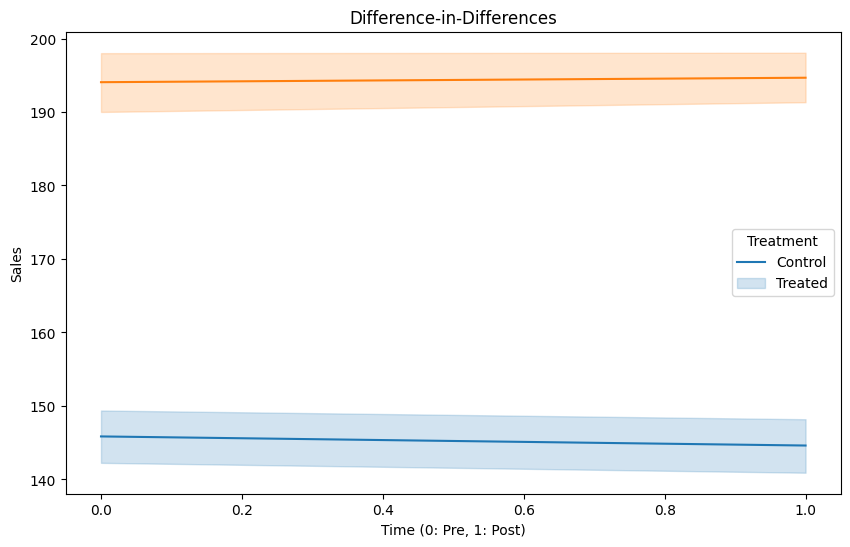

In [6]:
# 5. Difference-in-Differences (DiD)
def difference_in_differences(data):
    # Assume we have pre and post-treatment periods
    data['time'] = np.random.binomial(1, 0.5, len(data))  # 0 for pre, 1 for post
    
    # Calculate DiD estimator
    did_model = LinearRegression()
    X = pd.get_dummies(data[['treatment', 'time']], drop_first=True)
    X['interaction'] = data['treatment'] * data['time']
    y = data['sales']
    
    did_model.fit(X, y)
    
    print("\nDifference-in-Differences Results:")
    for feature, coef in zip(X.columns, did_model.coef_):
        print(f"{feature}: {coef}")
    print(f"Intercept: {did_model.intercept_}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x='time', y='sales', hue='treatment', err_style='band', ci=95)
    plt.title('Difference-in-Differences')
    plt.xlabel('Time (0: Pre, 1: Post)')
    plt.ylabel('Sales')
    plt.legend(title='Treatment', labels=['Control', 'Treated'])
    plt.show()

difference_in_differences(data)

In [7]:
!pip install pymc arviz

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.1 MB/s eta 0:00:00
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9098 sha256=e26eeb54fad9538968cbee5113523ac4c0fd3a3f8639300fee7e1244677ad60d
  Stored in directory: /root/.cache/pip/wheels/a4/11/f5/8265470e17d280d8b5910e1b0f298521420a5086d696e96799
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13911 sha256=75c33509aa98e0007cd21df23e44effc7fe6fae9c3d16d641821c5b80e5b2606
  Stored in directory: /root/.cache/pip/wheels/ba/95/1f/29d557452d7f5102769d

Output()


Bayesian Causal Inference Results:
              mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  169.450  0.320  168.830  170.039      0.004    0.003    5091.0   
betas[0]    26.089  0.320   25.486   26.690      0.004    0.003    6028.0   
betas[1]     9.694  0.317    9.119   10.294      0.004    0.003    6359.0   
betas[2]    -5.368  0.321   -6.004   -4.799      0.004    0.003    5542.0   
betas[3]    25.176  0.330   24.584   25.816      0.004    0.003    6173.0   

           ess_tail  r_hat  
intercept    3137.0    1.0  
betas[0]     3031.0    1.0  
betas[1]     2937.0    1.0  
betas[2]     2876.0    1.0  
betas[3]     2859.0    1.0  


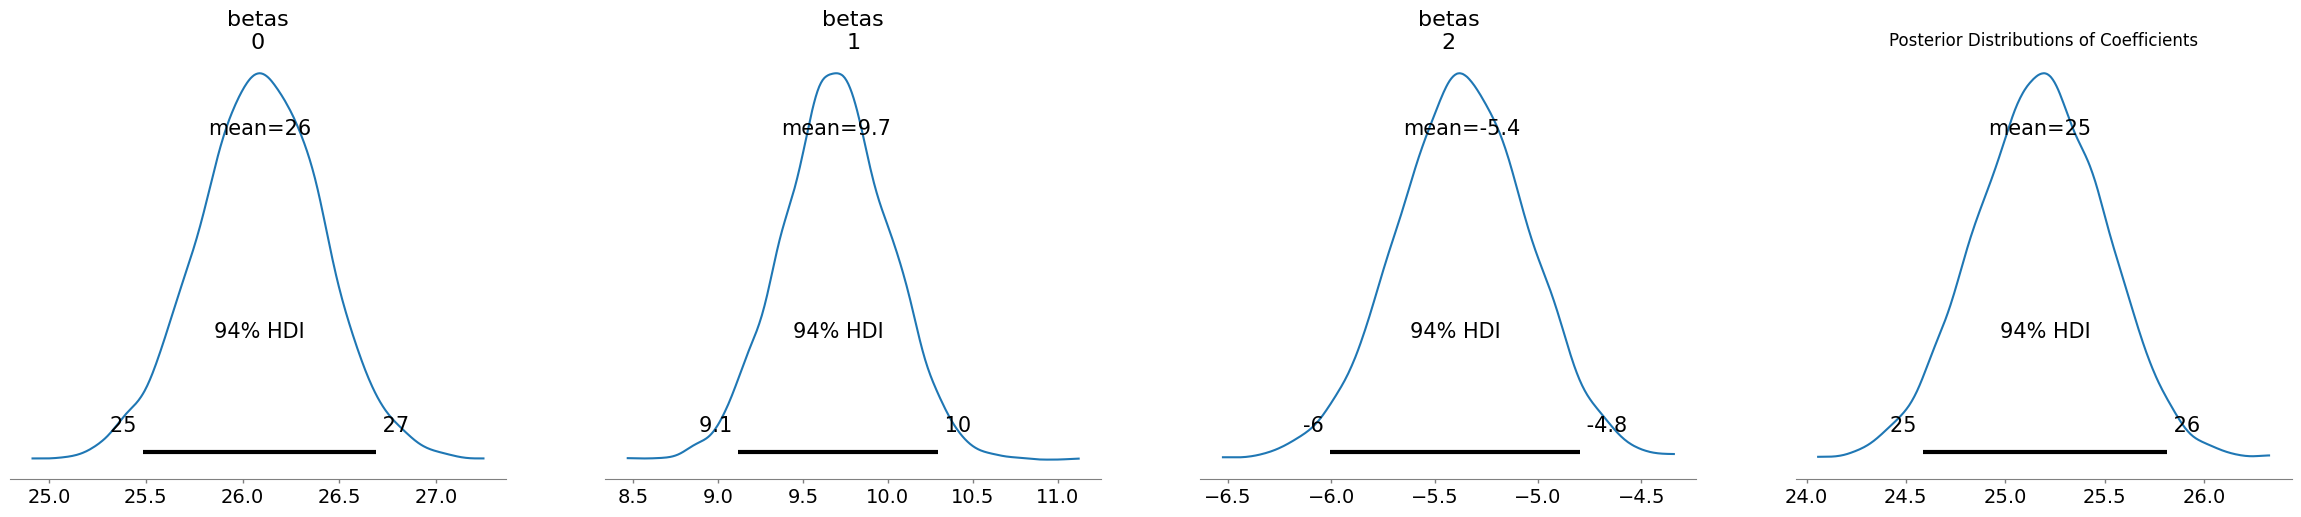

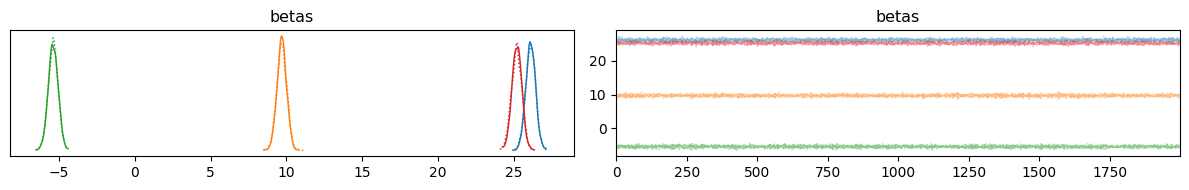

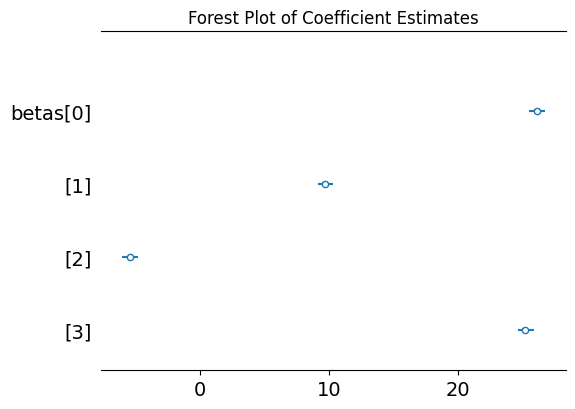

In [8]:
import pymc as pm
import arviz as az


def bayesian_causal_inference(data):
    # Prepare data
    X = data[['ad_spend', 'seasonality', 'competitor_activity', 'treatment']]
    y = data['sales']

    # Standardize continuous variables
    X_scaled = (X - X.mean()) / X.std()

    with pm.Model() as model:
        # Priors
        intercept = pm.Normal('intercept', mu=0, sigma=100)
        betas = pm.Normal('betas', mu=0, sigma=10, shape=X.shape[1])
        sigma = pm.HalfNormal('sigma', sigma=10)

        # Linear model
        mu = intercept + pm.math.dot(X_scaled, betas)

        # Likelihood
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

        # Inference
        trace = pm.sample(2000, tune=1000, return_inferencedata=True)

    # Print results
    print("\nBayesian Causal Inference Results:")
    summary = az.summary(trace, var_names=['intercept', 'betas'])
    print(summary)

    # Visualizations
    # Posterior distributions
    az.plot_posterior(trace, var_names=['betas'])
    plt.title('Posterior Distributions of Coefficients')
    plt.show()

    # Trace plots
    az.plot_trace(trace, var_names=['betas'])
    plt.tight_layout()
    plt.show()

    # Forest plot
    az.plot_forest(trace, var_names=['betas'], combined=True)
    plt.title('Forest Plot of Coefficient Estimates')
    plt.show()


# Create DataFrame
data = pd.DataFrame({
    'ad_spend': ad_spend,
    'seasonality': seasonality,
    'competitor_activity': competitor_activity,
    'treatment': treatment,
    'sales': sales
})

# Run the Bayesian analysis
bayesian_causal_inference(data)